# **Pairwise Sequence Alignment Demo**

# The Needleman-Wunsch Algorithm

The Needleman-Wunsch algorithm finds the optimal *global* alignment (end-to-end) between two sequences.
It consists of the following steps:

1. Construct the grid
2. Choose a scoring system (here we use the original scoring system assigning a score $s$ of 1 to a match, a score $s$ of -1 to a mismatch, and a score $d$ of -1 to a gap/indel)
3. Fill in the scoring matrix $F$ (and construct the pointer matrix on the way)
4. Use the pointer matrix to perform a traceback to recover the optimal warping path

The scores in the scoring matrix $F$ are computed using the already existing scores in the left, top-left, and top cells:

$$
F(i,j)=\max
\begin{cases}
    F(i-1,j-1)+s(x_i,y_i),\\
    F(i-1,j)+d,\\
    F(i,j-1)+d.
\end{cases}
$$

The following image illustrates the scoring and pointer matrices.

<img src="images/nw_matrix.png" width="500" />

We can use the `make_align()` function from our `alignment` module to generate an `align()` function that performs the Needleman-Wunsch algorithm.

In [1]:
import alignment as aln

x = "GATTACA"
y = "CATACCCA"

align = aln.make_align(mode="global")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

We can also plot the alignment together with the scoring matrix:

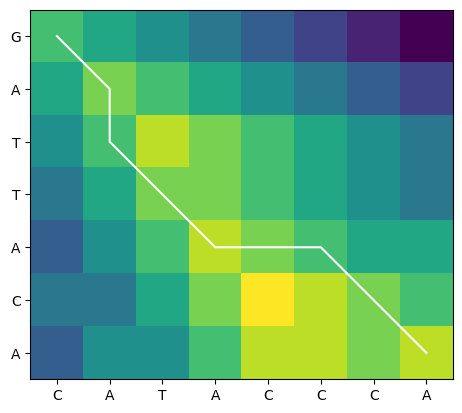

In [2]:
import matplotlib.pyplot as plt  # type: ignore

plt.imshow(X=scoring_mat)
plt.plot(warp_path_y, warp_path_x, "w")
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.show()

# The Smith-Waterman Algorithm

The Smith-Waterman algorithm finds the optimal *local* alignment between two sequences.
It is a variation of the Needleman-Wunsch algorithm.

The three main differences are:

|                | Smith-Waterman algorithm                                | Needleman-Wunsch algorithm                                                 |
|----------------|---------------------------------------------------------|----------------------------------------------------------------------------|
| Initialization | First row/column = 0                                    | First row/column subject to gap penalty                                    |
| Scoring        | Negative scores are set to 0                            | Scores can be negative                                                     |
| Traceback      | Begin with the highest score, end when 0 is encountered | Begin with the cell at the lower right of the matrix, end at top left cell |

Again, with our `alignment` module, we can perform the local alignment between the sequences `GATACCA` and `NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN`.

Multiple possible traceback starts: [ 5 16], [ 7 17]
Chose random traceback start from choices: [ 7 17]


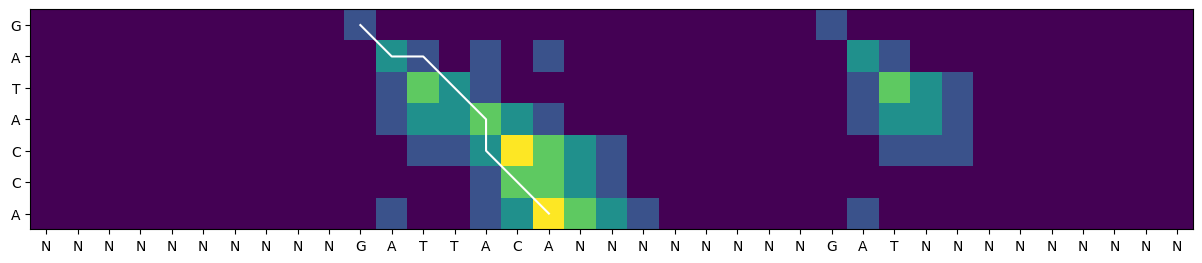

In [3]:
x = "GATACCA"
y = "NNNNNNNNNNGATTACANNNNNNNNGATNNNNNNNNN"

align = aln.make_align(mode="local")
x_aln, y_aln, warp_path_x, warp_path_y, scoring_mat = align(seq_a=x, seq_b=y)

plt.figure(figsize=(15, 8))
plt.imshow(X=scoring_mat)
plt.xticks(ticks=range(len(y)), labels=y)
plt.yticks(ticks=range(len(x)), labels=x)
plt.plot(warp_path_y, warp_path_x, "w")
plt.show()

# Read Alignment

We can also simulate the alignment of many reads originating from e.g., a bulk DNA sequencing experiment.

First, we simulate the generation of a number of reads, by sampling  5 reads from the reference sequence `GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA`.

In [4]:
import random

reference_sequence = "GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA"

n_reads = 20
min_read_len = 15
max_read_len = 25

reads = []

while len(reads) < n_reads:
    range_acquired = False
    while not range_acquired:
        start_position = random.randrange(len(reference_sequence))
        end_position = random.randrange(len(reference_sequence))
        if start_position > end_position:
            continue
        range_len = end_position - start_position + 1
        if range_len < min_read_len or range_len > max_read_len:
            continue
        range_acquired = True
        read = reference_sequence[start_position : (end_position + 1)]
        reads.append(read)

print(reads)

['AGTAAATCCATTTGTT', 'GGGGTTCAAAGCAGTATCGAT', 'CAGTATCGATCAAATA', 'TTTGGGGTTCAAAGCAGTATC', 'TCGATCAAATAGTAA', 'TCAAAGCAGTATCGATC', 'CAGTATCGATCAAATAGTAAATCC', 'AAGCAGTATCGATCAA', 'GGTTCAAAGCAGTATCGATCA', 'CGATCAAATAGTAAATCCATTT', 'ATAGTAAATCCATTTG', 'TAGTAAATCCATTTGTTC', 'TAAATCCATTTGTTCAACTCACA', 'TAAATCCATTTGTTCAACTCA', 'AAGCAGTATCGATCAAATAGTAAA', 'GGGTTCAAAGCAGTATC', 'TATCGATCAAATAGTAAATCCATTT', 'GCAGTATCGATCAAATAGTAAAT', 'GCAGTATCGATCAAATAGTAAAT', 'CAAATAGTAAATCCATTTGTT']


Next we add some noise to the sampled reads.

In [5]:
def add_noise(read: str, noiselessness: int = 4) -> tuple[str, int]:
    """Add noise to a read."""
    choices = ["A", "C", "G", "T"]
    n_noisy_bases = 0
    noisy_read = ""
    for base in read:
        if not random.randrange(noiselessness):
            noisy_read += random.choice(seq=[c for c in choices if c != base])
            n_noisy_bases += 1
        else:
            noisy_read += base
    return noisy_read, n_noisy_bases


noisy_reads = []
for read in reads:
    noisy_read, n_noisy_bases = add_noise(read=read, noiselessness=3)
    print(f"Added {n_noisy_bases:2} noisy base(s): {read:10s} -> {noisy_read:10s}")
    noisy_reads.append(noisy_read)

Added  7 noisy base(s): AGTAAATCCATTTGTT -> TGCCGATCCGTTCGTC
Added  8 noisy base(s): GGGGTTCAAAGCAGTATCGAT -> GCTCTTCTAAGGAATGTCGCT
Added  5 noisy base(s): CAGTATCGATCAAATA -> CAGTCCCCATAAACTA
Added 10 noisy base(s): TTTGGGGTTCAAAGCAGTATC -> TCTCGCGTTCATAAACATAGA
Added  1 noisy base(s): TCGATCAAATAGTAA -> TCGATAAAATAGTAA
Added  9 noisy base(s): TCAAAGCAGTATCGATC -> GCCATGTCTCCTGGATC
Added 10 noisy base(s): CAGTATCGATCAAATAGTAAATCC -> CCATCCGGACCTAACACTTAATCC
Added  5 noisy base(s): AAGCAGTATCGATCAA -> AAGAAGGAGCGATGGA
Added  8 noisy base(s): GGTTCAAAGCAGTATCGATCA -> GTTTGAAACTAGTATGGAAAT
Added  7 noisy base(s): CGATCAAATAGTAAATCCATTT -> CGATCTGACCATAAATTTATTT
Added  4 noisy base(s): ATAGTAAATCCATTTG -> ATTATAAATCCATAGG
Added  5 noisy base(s): TAGTAAATCCATTTGTTC -> TAGGTCATCCATTTTTTA
Added  4 noisy base(s): TAAATCCATTTGTTCAACTCACA -> GGAATCCATTTGTTCAACAGACA
Added 10 noisy base(s): TAAATCCATTTGTTCAACTCA -> GTAACCTGTGAGTTCCAATCG
Added  8 noisy base(s): AAGCAGTATCGATCAAATAGTAAA -> AATCATTA

We now align the noisy reads locally to the reference sequence.

Multiple possible traceback starts: [15 46], [16 48]
Chose random traceback start from choices: [15 46]
Read                      : TGCCGATCCGTTCGTC
Mapping position (0-based): 36
Aligned read              : ATCCGTTCGT
Aligned read w/o gaps     : ATCCGTTCGT
Number of clipped bases   : 6
Reference subsequence     : ATCCATTTGT


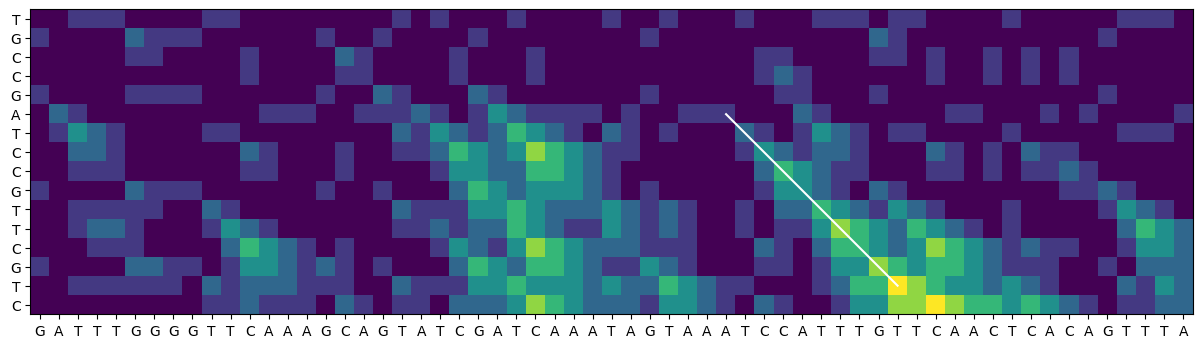

Multiple possible traceback starts: [19 24], [21 26]
Chose random traceback start from choices: [21 26]
Read                      : GCTCTTCTAAGGAATGTCGCT
Mapping position (0-based): 9
Aligned read              : TTCTAAGGAATGTCGCT
Aligned read w/o gaps     : TTCTAAGGAATGTCGCT
Number of clipped bases   : 4
Reference subsequence     : TTCAAAGCAGTATCGAT


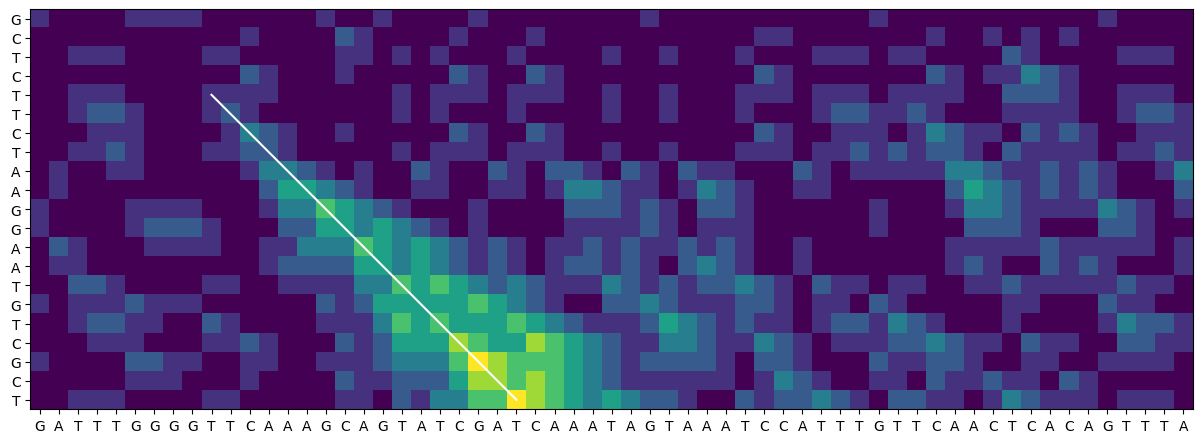

Read                      : CAGTCCCCATAAACTA
Mapping position (0-based): 16
Aligned read              : CAGTCCCCAT-AAACTA
Aligned read w/o gaps     : CAGTCCCCATAAACTA
Number of clipped bases   : 0
Reference subsequence     : CAGTATCGATCAAATA


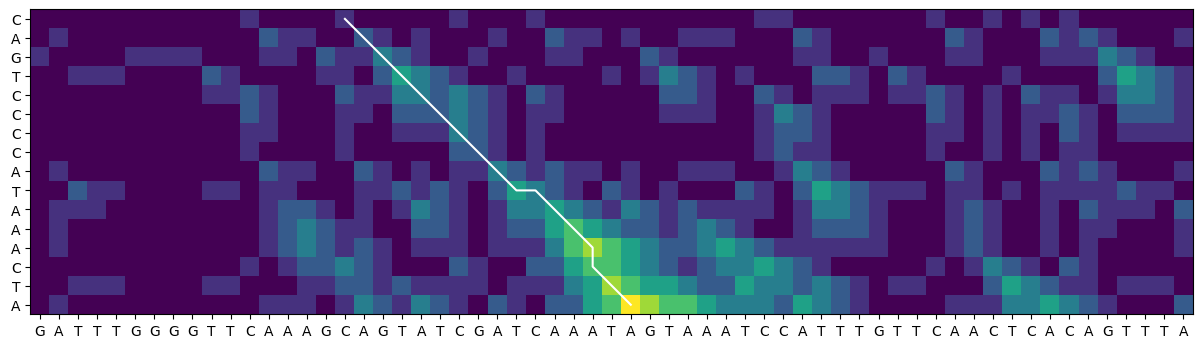

Multiple possible traceback starts: [20 33], [21 35]
Chose random traceback start from choices: [21 35]
Read                      : TCTCGCGTTCATAAACATAGA
Mapping position (0-based): 15
Aligned read              : GC-GT-TC-ATAAACATAG-A
Aligned read w/o gaps     : GCGTTCATAAACATAGA
Number of clipped bases   : 4
Reference subsequence     : GCAGTATCGATCAAATAGTA


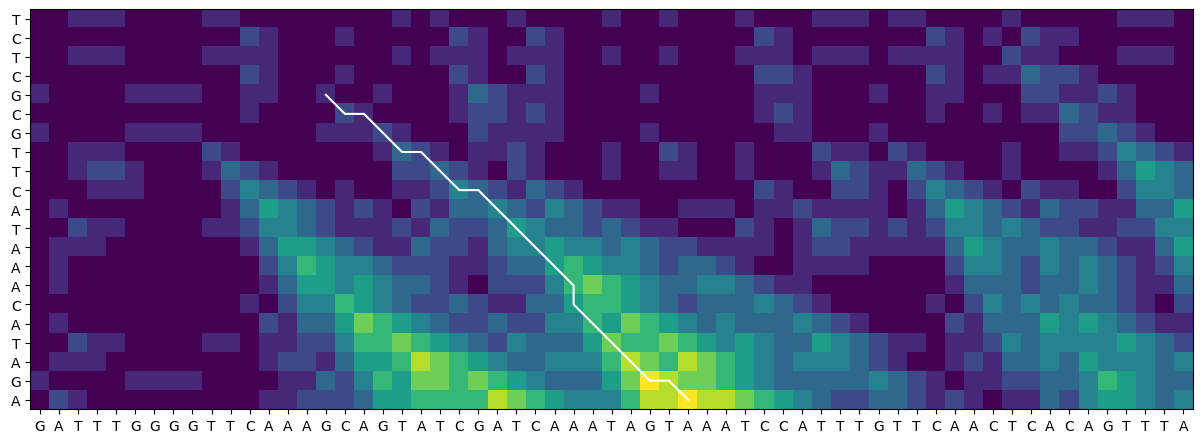

Read                      : TCGATAAAATAGTAA
Mapping position (0-based): 21
Aligned read              : TCGATAAAATAGTAA
Aligned read w/o gaps     : TCGATAAAATAGTAA
Number of clipped bases   : 0
Reference subsequence     : TCGATCAAATAGTAA


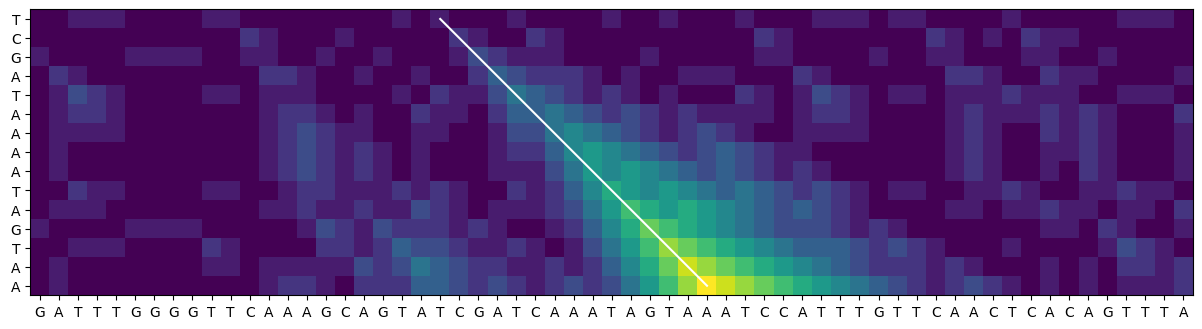

Multiple possible traceback starts: [10 48], [12 52], [17 27]
Chose random traceback start from choices: [12 52]
Read                      : GCCATGTCTCCTGGATC
Mapping position (0-based): 38
Aligned read              : CCA--TGTCTC--CT
Aligned read w/o gaps     : CCATGTCTCCT
Number of clipped bases   : 6
Reference subsequence     : CCATTTGTTCAACT


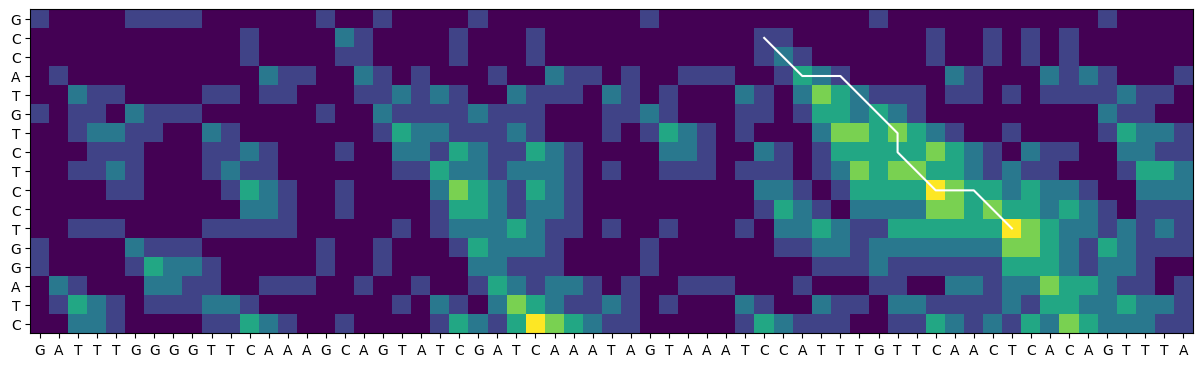

Read                      : CCATCCGGACCTAACACTTAATCC
Mapping position (0-based): 20
Aligned read              : ATCCGGACCTAACACTTAATCC
Aligned read w/o gaps     : ATCCGGACCTAACACTTAATCC
Number of clipped bases   : 2
Reference subsequence     : ATCGATCAAATAGTAAATCC


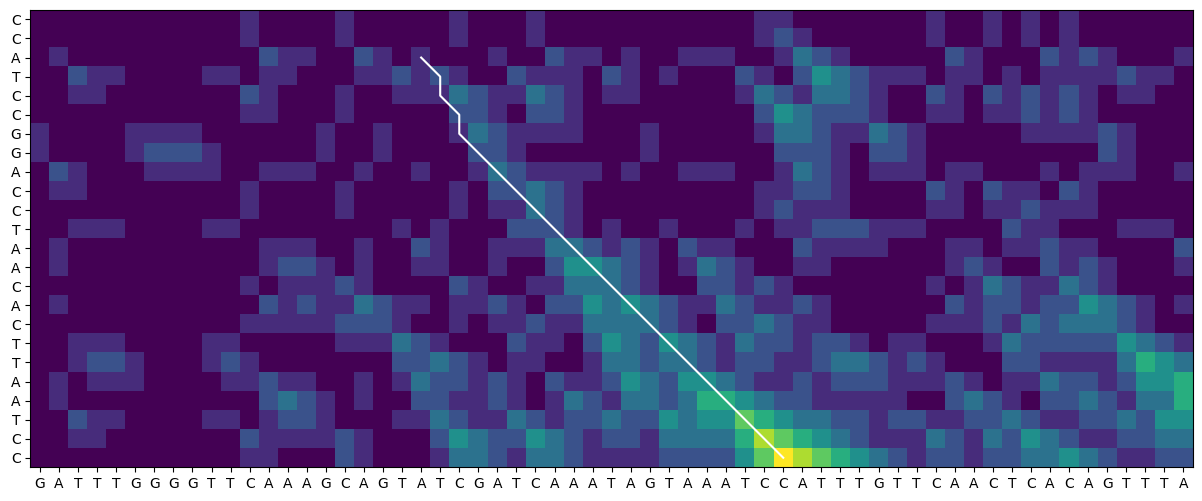

Read                      : AAGAAGGAGCGATGGA
Mapping position (0-based): 13
Aligned read              : AAGAAGGAGCGAT
Aligned read w/o gaps     : AAGAAGGAGCGAT
Number of clipped bases   : 3
Reference subsequence     : AAGCAGTATCGAT


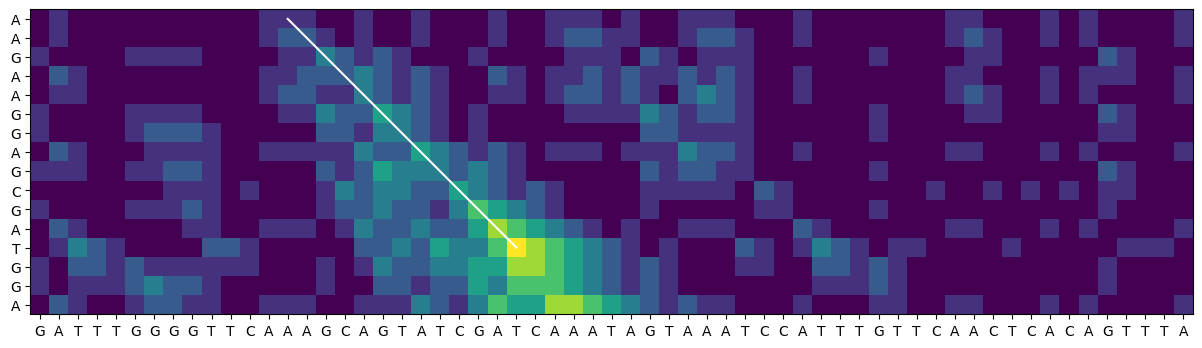

Multiple possible traceback starts: [18 25], [20 29], [21 31]
Chose random traceback start from choices: [20 29]
Read                      : GTTTGAAACTAGTATGGAAAT
Mapping position (0-based): 9
Aligned read              : TTGAAA-CTAGTATGGA--AA
Aligned read w/o gaps     : TTGAAACTAGTATGGAAA
Number of clipped bases   : 3
Reference subsequence     : TTCAAAGCAGTATCGATCAA


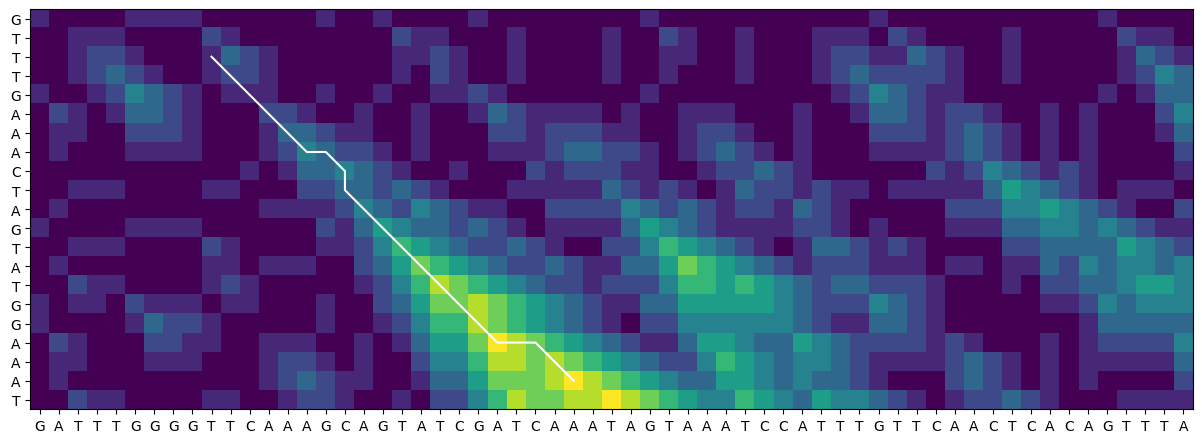

Read                      : CGATCTGACCATAAATTTATTT
Mapping position (0-based): 22
Aligned read              : CGATCTGACCA-TAAATTTATTT
Aligned read w/o gaps     : CGATCTGACCATAAATTTATTT
Number of clipped bases   : 0
Reference subsequence     : CGATCAAATAGTAAATCCATTT


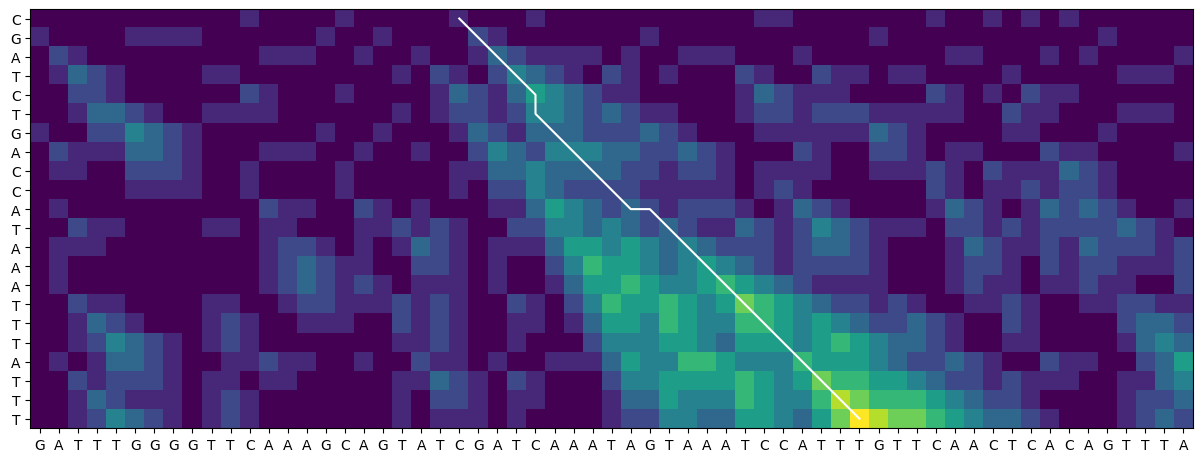

Read                      : ATTATAAATCCATAGG
Mapping position (0-based): 30
Aligned read              : TA-TAAATCCAT
Aligned read w/o gaps     : TATAAATCCAT
Number of clipped bases   : 5
Reference subsequence     : TAGTAAATCCAT


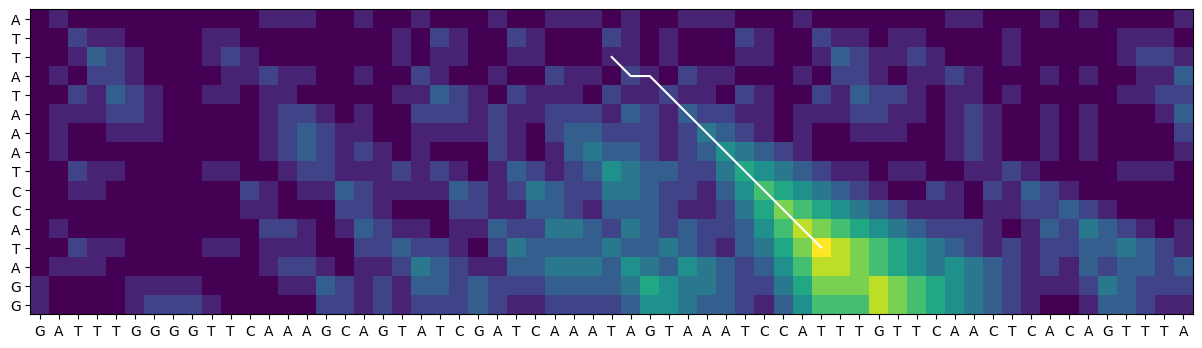

Multiple possible traceback starts: [16 47], [17 47], [18 49]
Chose random traceback start from choices: [17 47]
Read                      : TAGGTCATCCATTTTTTA
Mapping position (0-based): 30
Aligned read              : TAGGT-CATCCATTTTTT
Aligned read w/o gaps     : TAGGTCATCCATTTTTT
Number of clipped bases   : 1
Reference subsequence     : TAGTAAATCCATTTGTT


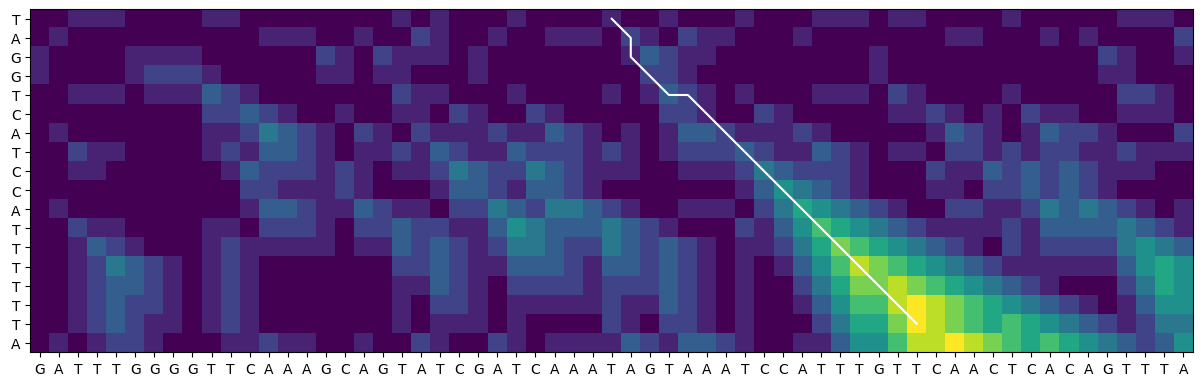

Read                      : GGAATCCATTTGTTCAACAGACA
Mapping position (0-based): 35
Aligned read              : AATCCATTTGTTCAACAGACA
Aligned read w/o gaps     : AATCCATTTGTTCAACAGACA
Number of clipped bases   : 2
Reference subsequence     : AATCCATTTGTTCAACTCACA


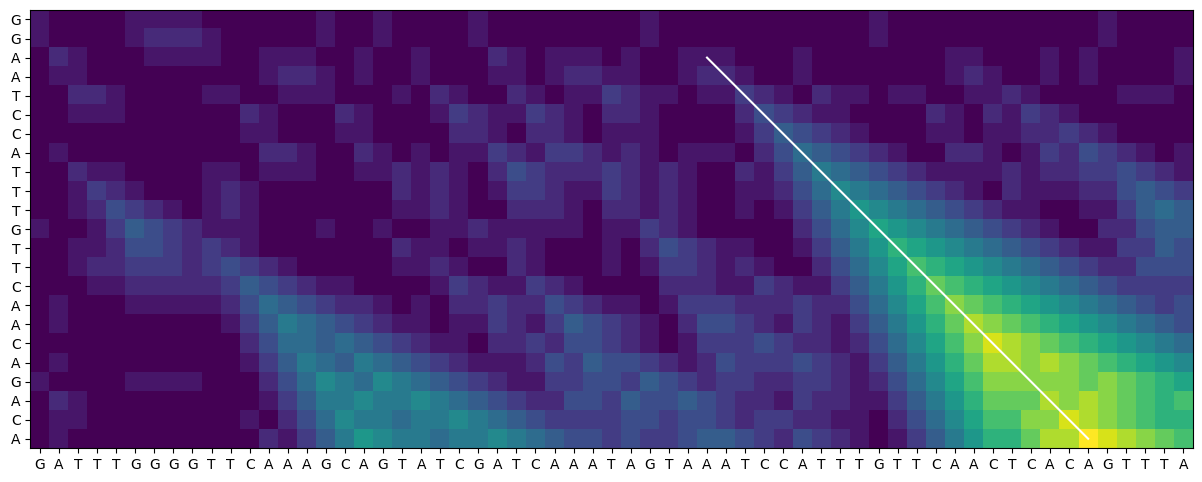

Read                      : GTAACCTGTGAGTTCCAATCG
Mapping position (0-based): 32
Aligned read              : GT-AA-CC-TGTGAGTTCCAA-TC
Aligned read w/o gaps     : GTAACCTGTGAGTTCCAATC
Number of clipped bases   : 1
Reference subsequence     : GTAAATCCATTTGTTCAACTC


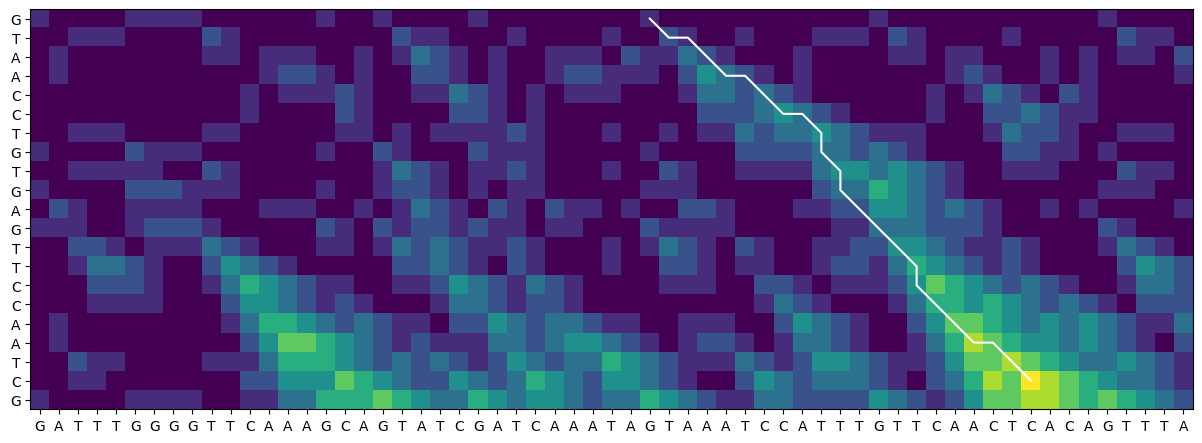

Read                      : AATCATTATCGCACACACCATAAA
Mapping position (0-based): 13
Aligned read              : AATCATTATCGCA-CACACCA-TAAA
Aligned read w/o gaps     : AATCATTATCGCACACACCATAAA
Number of clipped bases   : 0
Reference subsequence     : AAGCAGTATCGATCAAATAGTAAA


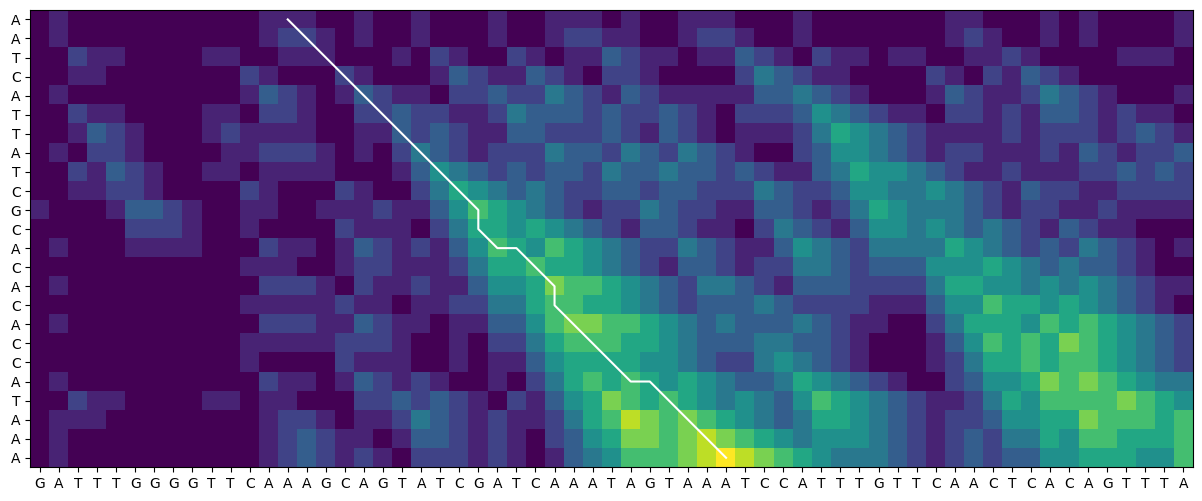

Read                      : TGGTTGAATTCAGAAGT
Mapping position (0-based): 44
Aligned read              : GTTGAATTCAGAAGT
Aligned read w/o gaps     : GTTGAATTCAGAAGT
Number of clipped bases   : 2
Reference subsequence     : GTTCAACTCACAGT


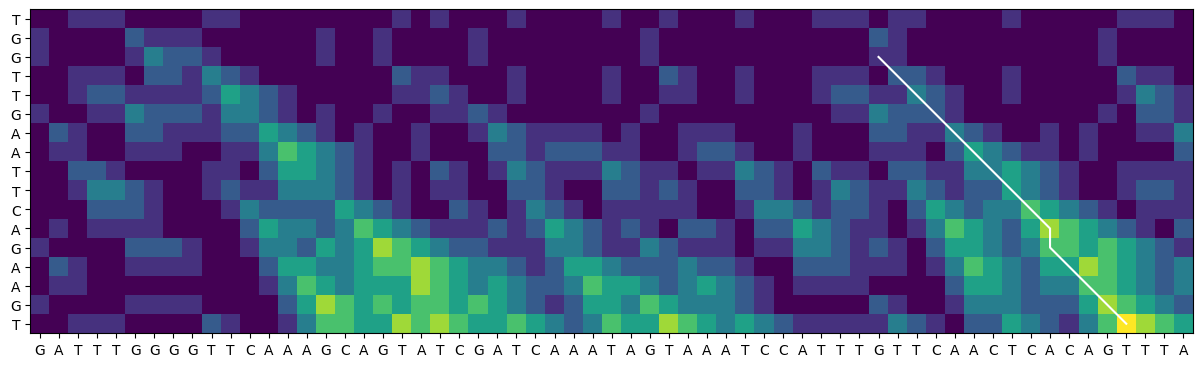

Read                      : TATCGTTCAAATAATCAATGCATTT
Mapping position (0-based): 19
Aligned read              : TATCGTTCAAATAATCAATGCATTT
Aligned read w/o gaps     : TATCGTTCAAATAATCAATGCATTT
Number of clipped bases   : 0
Reference subsequence     : TATCGATCAAATAGTAAATCCATTT


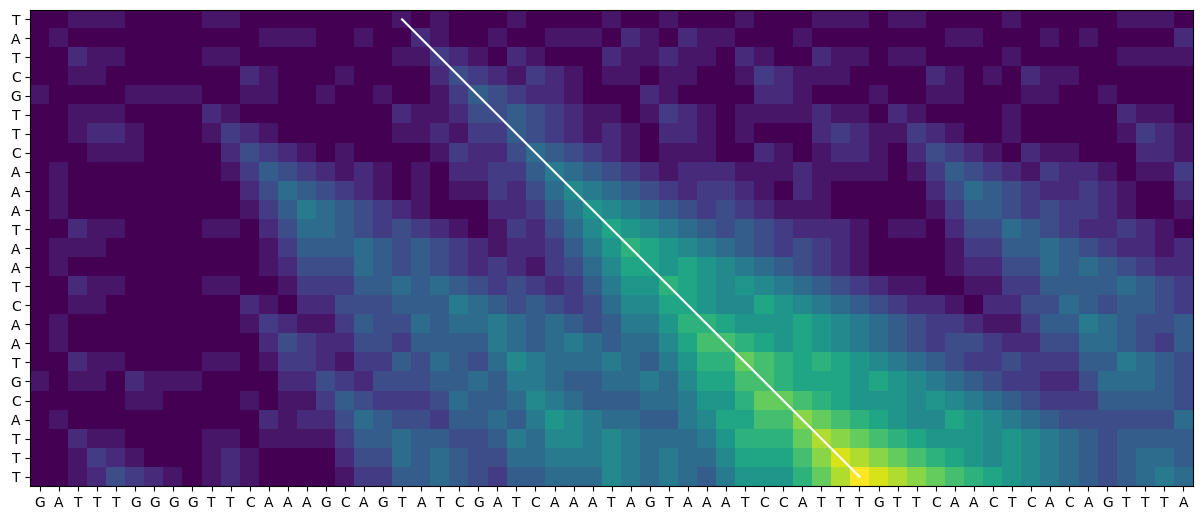

Read                      : GCCGTATCTATGCCAGAGTCAAT
Mapping position (0-based): 15
Aligned read              : GCCGTATCTATGC-CAGAGTCAAT
Aligned read w/o gaps     : GCCGTATCTATGCCAGAGTCAAT
Number of clipped bases   : 0
Reference subsequence     : GCAGTATCGATCAAATAGTAAAT


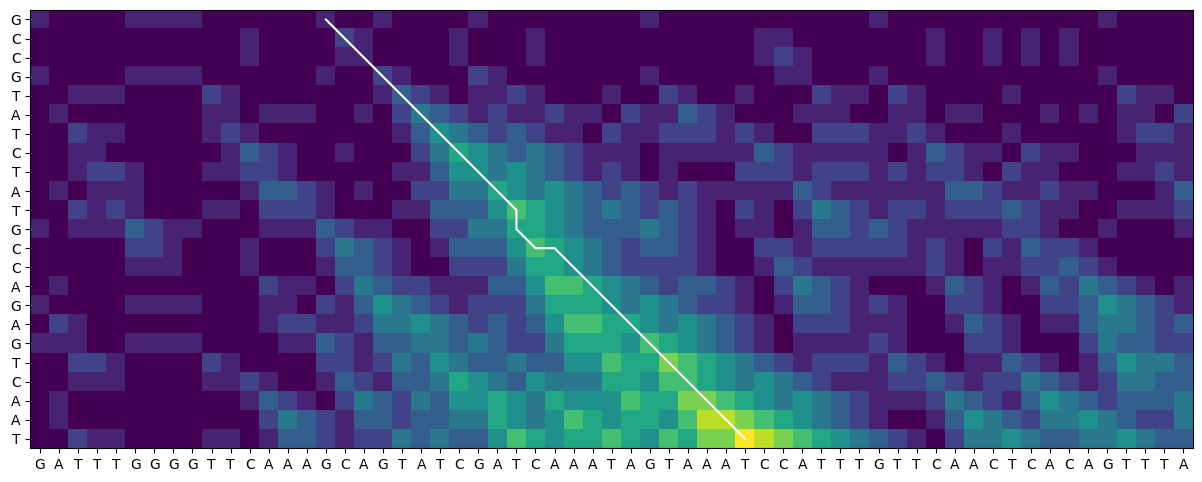

Multiple possible traceback starts: [21 36], [23 38]
Chose random traceback start from choices: [21 36]
Read                      : GCACTGTCGATCAACTCGTAAGT
Mapping position (0-based): 15
Aligned read              : GCACTGTCGATCAACTCGTAA
Aligned read w/o gaps     : GCACTGTCGATCAACTCGTAA
Number of clipped bases   : 2
Reference subsequence     : GCAGTATCGATCAAATAGTAA


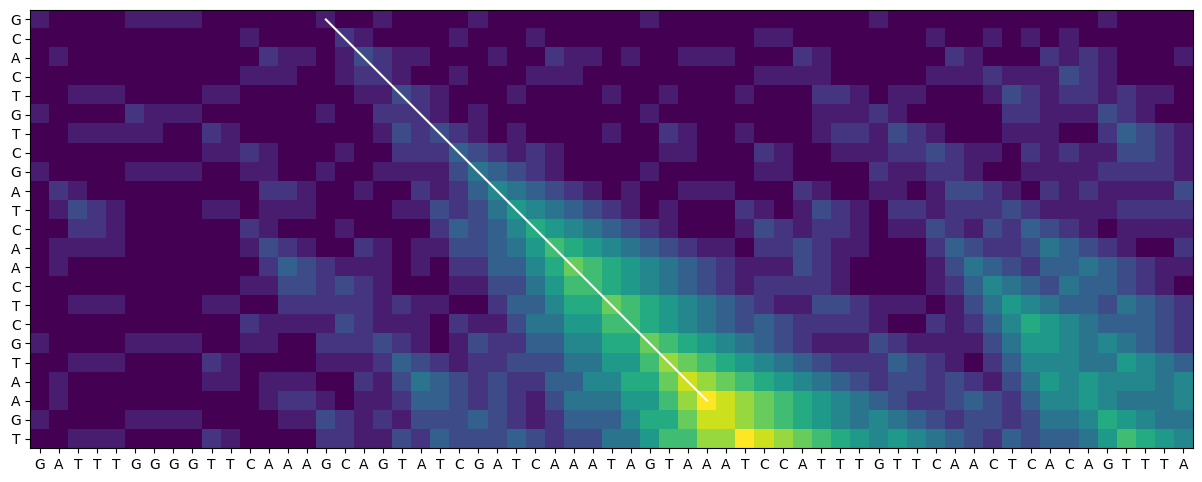

Multiple possible traceback starts: [20 46], [21 48]
Chose random traceback start from choices: [20 46]
Read                      : AAAAACGTTAATTCTTTTGTC
Mapping position (0-based): 27
Aligned read              : AAAAACGTTAATTCTTTTGT
Aligned read w/o gaps     : AAAAACGTTAATTCTTTTGT
Number of clipped bases   : 1
Reference subsequence     : AAATAGTAAATCCATTTGT


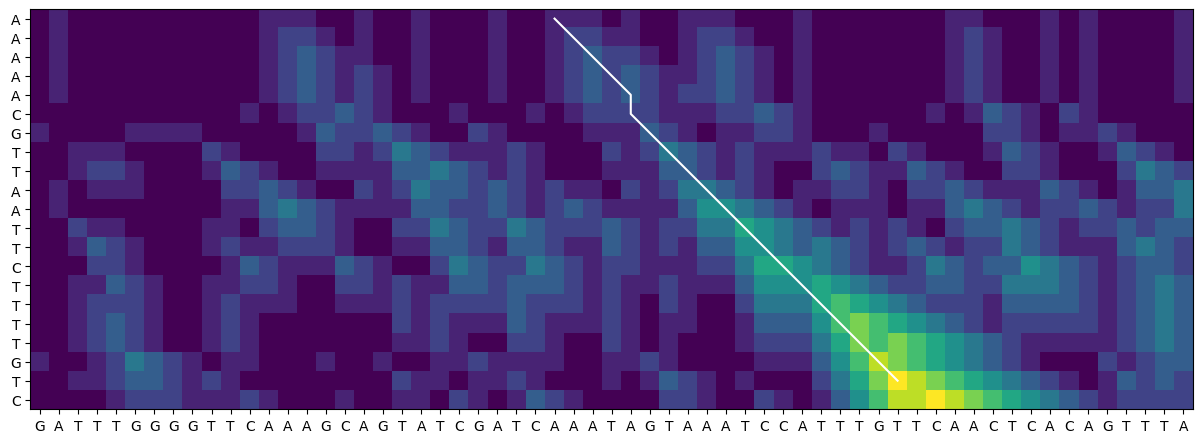

In [6]:
mapping_positions = []
aligned_reads = []

for read in noisy_reads:
    align = aln.make_align(mode="local")
    read_aln, ref_aln, warp_path_read, warp_path_ref, scoring_mat = align(
        seq_a=read, seq_b=reference_sequence
    )

    mapping_position = warp_path_ref[0]
    aligned_read = "".join(read_aln)
    mapping_positions.append(mapping_position)
    aligned_reads.append(aligned_read)

    print(f"Read                      : {read}")
    print(f"Mapping position (0-based): {mapping_position}")
    print(f"Aligned read              : {aligned_read}")
    aligned_read_without_gaps = list(filter(lambda elem: elem != "-", read_aln))
    print(f"Aligned read w/o gaps     : {''.join(aligned_read_without_gaps)}")
    print(f"Number of clipped bases   : {len(read) - len(aligned_read_without_gaps)}")
    print(
        f"Reference subsequence     : "
        f"{reference_sequence[warp_path_ref[0] : (warp_path_ref[-1] + 1)]}"
    )

    plt.figure(figsize=(15, 8))
    plt.imshow(X=scoring_mat)
    plt.plot(warp_path_ref, warp_path_read, "w")
    plt.xticks(ticks=range(len(reference_sequence)), labels=reference_sequence)
    plt.yticks(ticks=range(len(read)), labels=read)
    plt.show()

We now have the following set of aligned reads:

In [7]:
print(f"Reference: {reference_sequence}")
for i, (pos, seq) in enumerate(zip(mapping_positions, aligned_reads)):
    print(f"Read {i:4}: {' ' * pos}{seq}")

Reference: GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTTA
Read    0:                                     ATCCGTTCGT
Read    1:          TTCTAAGGAATGTCGCT
Read    2:                 CAGTCCCCAT-AAACTA
Read    3:                GC-GT-TC-ATAAACATAG-A
Read    4:                      TCGATAAAATAGTAA
Read    5:                                       CCA--TGTCTC--CT
Read    6:                     ATCCGGACCTAACACTTAATCC
Read    7:              AAGAAGGAGCGAT
Read    8:          TTGAAA-CTAGTATGGA--AA
Read    9:                       CGATCTGACCA-TAAATTTATTT
Read   10:                               TA-TAAATCCAT
Read   11:                               TAGGT-CATCCATTTTTT
Read   12:                                    AATCCATTTGTTCAACAGACA
Read   13:                                 GT-AA-CC-TGTGAGTTCCAA-TC
Read   14:              AATCATTATCGCA-CACACCA-TAAA
Read   15:                                             GTTGAATTCAGAAGT
Read   16:                    TATCGTTCAAATAATCAATGCATTT
Read  

# Variant Calling

Variant calling is a crucial step in analyzing DNA sequence data to identify differences or variations in the genetic code of individuals.
This process involves comparing an individual's DNA sequence (in the form of aligned reads) to a reference sequence to pinpoint variations such as single nucleotide polymorphisms (SNPs), insertions, deletions, and structural alterations.

While there exist many sophisticated variant calling algorithms such as [GATK](https://gatk.broadinstitute.org)'s [HaplotypeCaller](https://gatk.broadinstitute.org/hc/en-us/articles/360037225632-HaplotypeCaller), we will here focus on SNPs only and perform a simple majority voting per locus.

In [8]:
from collections import Counter

pileups = [[] for _ in range(len(reference_sequence))]
snps = {}

# Accumulate the pileups.
for pos, seq in zip(mapping_positions, aligned_reads):
    for offset, _ in enumerate(seq):
        # It may happen that an aligned read extends beyond the reference sequence.
        # We decided not to generate additional pileups, and hence, we will just ignore
        # the overhanging bases.
        pileup_index = pos + offset
        if pileup_index < len(reference_sequence):
            pileups[pileup_index].append(seq[offset])

# SNP calling via majority voting.
print("POS   REF   MAJ   SNP   PILEUP")
for i, pileup in enumerate(pileups):
    majority_base = ""
    snp = "-"

    # Make a pileup string.
    pileup = "".join(pileup)

    # We can only call variants for non-empty pileups.
    if pileup:
        # Count the occurrences of each character in the pileup.
        char_counts = Counter(pileup)
        # Find the most common character.
        majority_base, _ = char_counts.most_common(n=1)[0]
    # No variant if the pileup is empty.
    else:
        majority_base = "-"

    # Call it if it's a SNP.
    if majority_base != "-" and majority_base != reference_sequence[i]:
        snp = majority_base
        snps[i] = snp

    print(f"{i:3}   {reference_sequence[i]:3}   {majority_base:3}   {snp:3}   {pileup}")

POS   REF   MAJ   SNP   PILEUP
  0   G     -     -     
  1   A     -     -     
  2   T     -     -     
  3   T     -     -     
  4   T     -     -     
  5   G     -     -     
  6   G     -     -     
  7   G     -     -     
  8   G     -     -     
  9   T     T     -     TT
 10   T     T     -     TT
 11   C     C     -     CG
 12   A     T     T     TA
 13   A     A     -     AAAA
 14   A     A     -     AAAA
 15   G     G     -     GGG-TGG
 16   C     C     -     GCCACCCC
 17   A     A     -     AA-ATACA
 18   G     G     -     AGGGATGC
 19   T     T     -     TTTGGTTTT
 20   A     A     -     GC-AATAAAG
 21   T     T     -     TCTTTGATTTT
 22   C     C     -     CCCCCCTCCCCC
 23   G     G     -     GC-GCGGGGGTG
 24   A     A     -     CAAAGAGACTAA
 25   T     T     -     TTTTGTATATTT
 26   C     -     -     -AAA-C-CGC
 27   A     A     -     AAAC-TCACAA
 28   A     A     -     AAACAGAA-AA
 29   A     A     -     ACATAACACCA
 30   T     A     A     CATACTTATATA
 31   A     A 

In [9]:
# List all SNPs.
print("POS   SNP")
for pos, snp in snps.items():
    print(f"{pos:3}   {snp:3}")

POS   SNP
 12   T  
 30   A  
 32   A  
 34   T  
 37   A  
 47   T  
 51   A  
 52   T  
 56   A  
 57   G  
